The aim here is to remove the light of large, extended objects and detect faint objects underneath. Then I measure the shape parameters and magnitudes of the sources. A fits catalogue of all compact sources is then saved. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm
from scipy.ndimage import median_filter, gaussian_filter, generic_filter
from functools import partial

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table, vstack
from astropy import units as u
from astropy import wcs

#These use photutils version 1.9 or above
from photutils.centroids import centroid_com
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder, find_peaks
from photutils.background import Background2D, MedianBackground

In [2]:
# This program takes:
# image data (data), 
# a table which must include 2 columns: table['xcentroid'], table['ycentroid'], which are the x and y coordinates of the detections in the wcs_cat image, 
# aperture - which is the radius of the aperture you wish to measure your flux (in pixels with pixel scale from wcs_cat image)
# zp - zeropoint of data
# string - string to identify flux measurement in the output table

# The program outputs table with 2 additional columns - the background subtracted flux and magnitude in the aperture.

def measure_flux_bkgsub(data, table, aperture, inner_annulus, outer_annulus, zp,string):
    from astropy.stats import SigmaClip
    from photutils.aperture import ApertureStats
    from photutils.aperture import CircularAperture, CircularAnnulus
    
    positions = np.transpose((table['xcentroid'], table['ycentroid']))
     #defines the position that we measure flux
    
    aperture = CircularAperture(positions, r=aperture)
     # defines the circular apertures to measure flux. These are in pixel coordinates
    
    annulus_aperture = CircularAnnulus(positions, r_in=inner_annulus, r_out=outer_annulus)
     # defines the circular annulus to measure background flux. These are in pixel coordinates
   
    aper_stats = ApertureStats(data, aperture, sigma_clip=None)
     #calculate statistics of data (i.e. total flux) within pixel aperture. 
    
    sigclip = SigmaClip(sigma=3.0, maxiters=10)    
    bkg_stats = ApertureStats(data, annulus_aperture, sigma_clip=sigclip)
    #calculate statistics of data (i.e. total flux) within pixel-defined annulus. Remove some pixel data using sigma clipping
    
    total_bkg = bkg_stats.median * aper_stats.sum_aper_area.value
     # Calculate the background in the aperature as the median of the flux in the annulus * area of the aperture
    
    apersum_bkgsub = aper_stats.sum - total_bkg
    # Calculate the background subtracted aperature flux as the total flux in the aperture - total_bkg (measured above)
    
    
    table['total_flux_'+string] = aper_stats.sum
    table['bkg_'+string] = total_bkg
    table['flux_bkgsub_'+string] = apersum_bkgsub
    below_level=(apersum_bkgsub < 0)
    table['mag_'+string]=zp-2.5*np.log10(apersum_bkgsub)
    table['mag_'+string][below_level]=-99
    return table

In [3]:
# This program takes:
#radius in pixels
# outputs a circular footprint of a given radius 
def footprint_circle(radius):
    footprint = np.zeros((2*radius+1, 2*radius+1))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    footprint[x**2 + y**2 <= radius**2] = 1 
    return footprint

In [4]:
# This program takes:
#radius in pixels
# outputs a circular footprint of a given radius 
def footprint_ring(radiusin, radiusout):
    footprint = np.zeros((2*radiusout+1, 2*radiusout+1))
    y, x = np.ogrid[-radiusout:radiusout+1, -radiusout:radiusout+1]
    footprint[x**2 + y**2 <= radiusout**2] = 1 
    footprint[x**2 + y**2 <= radiusin**2] = 0 
    return footprint

Using ERO Euclid image. Need to read it in twice.

In [5]:
hdul = fits.open('Euclid-VIS-ERO-Perseus-LSB.v9.fits', memmap=True)
img = hdul[0].data
header = hdul[0].header
WCS_v7 = wcs.WCS(hdul[0].header)
hdul_o = fits.open('Euclid-VIS-ERO-Perseus-LSB.v9.fits', memmap=True)
img_original = hdul_o[0].data

I filter the image. I create another arrary of the same size as img. For every point, I measure the median of img within a circular footprint of 20 pixel radius. 
Then I subtract this median from the image. This image is used the measure the shape parameters and fluxes. The size of 20 should be large enough to leave the shape of the compact sources intact in the filtered image.

In [6]:
%time medfilt = median_filter(img, footprint=footprint_circle(20), mode='nearest')
img20 = hdul[0].data-medfilt
filtered_file='VISv9_20.fits'
fits.PrimaryHDU(data=img20.astype(np.single), header=header).writeto(filtered_file, overwrite=True) 
filtered_file='VISv9_median_20.fits'
fits.PrimaryHDU(data=medfilt.astype(np.single), header=header).writeto(filtered_file, overwrite=True) 
#files are saved so you don't need to run this step multiple times

flat=img20

CPU times: user 2min 53s, sys: 6.67 s, total: 3min
Wall time: 3min 13s


I filter the image again. I create another arrary of the same size as img. For every point, I measure the median of img within a ring footprint of inner = 2 and outer=4 pixels. 
Then I subtract this median from the image. This image is used to detect the sources. 
The inner radius must be approximately the size of the objects you wish to isolate, i.e. GCs. 

In [7]:
%time medfilt = median_filter(img, footprint=footprint_ring(2,4), mode='nearest')
img -= medfilt
filtered_file='VISv9_median_ring24.fits'
fits.PrimaryHDU(data=medfilt.astype(np.single), header=header).writeto(filtered_file, overwrite=True) 

filtered_file='VISv9_ring24.fits'
fits.PrimaryHDU(data=img.astype(np.single), header=header).writeto(filtered_file, overwrite=True) 

filtered_data=img

CPU times: user 7min 58s, sys: 8.82 s, total: 8min 7s
Wall time: 8min 22s


Now detect stellar sources using source detection

In [8]:
#parameters for detection
bkg_estimator = MedianBackground()
threshold_limit=3 
connected_pixels=3

Below I have a loop and I have to divide the image into 4 because the ERO data is too large. For smaller images, including NISP data, I don't need this loop so you can probably remove it

In [9]:
#make cutouts of the original file
#This is needed because the original image is too large for my computer.
cut_x=[0,21001,0,21001]
cut_x2=[21100,42000,21100,42000]
cut_y=[0,0,21001,21001]
cut_y2=[21100,21100,42000,42000]

In [13]:
for i in range(0, 4):
    #this loop runs over 4 quadrants of the image with about 100 pixels overlap
    bkg = Background2D(filtered_data[cut_x[i]:cut_x2[i],cut_y[i]:cut_y2[i]], (15, 15), #filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
    #estimate background in the ring filtered image
    bkg_orig = Background2D(flat[cut_x[i]:cut_x2[i],cut_y[i]:cut_y2[i]], (50, 50),
                   bkg_estimator=bkg_estimator)
    #estimate background in the 20-pixel filtered image
    
    threshold =threshold_limit * bkg.background_rms
    #detection threshold defined as some multiple of background rms image.
    
    segment_map = detect_sources(filtered_data[cut_x[i]:cut_x2[i],cut_y[i]:cut_y2[i]], threshold, npixels=connected_pixels)#, mask=weight[cut_x[i]:cut_x2[i],cut_y[i]:cut_y2[i]])
    #this command detects sources in the ring-filtered image
    
    cat = SourceCatalog(flat[cut_x[i]:cut_x2[i],cut_y[i]:cut_y2[i]],segment_map,background=bkg_orig.background,wcs=WCS_v7)
    
    cat2 = SourceCatalog(filtered_data[cut_x[i]:cut_x2[i],cut_y[i]:cut_y2[i]],segment_map,wcs=WCS_v7)
  
    #two catalogues are created. CAT = parameters from 20-pixel filtered image, CAT2 = parameters from filtered image.
    
    #making into a catalogue
    columns = ['area', 'semimajor_sigma', 'semiminor_sigma','ellipticity', 'elongation']
    tbl = cat.to_table(columns=columns)
    
    columns = ['xcentroid','ycentroid']
    tbl2 = cat2.to_table(columns=columns)
    #take centroids from filtered images
    
    #take morpholoigcal/shape parameters from 20-pixel filtered image
    tbl2['area']=tbl['area']
    tbl2['semimajor_sigma']=tbl['semimajor_sigma']
    tbl2['semiminor_sigma']=tbl['semiminor_sigma']
    tbl2['FWHM']=2*np.sqrt(np.log(2)*(tbl['semimajor_sigma']*tbl['semimajor_sigma'])+(tbl['semiminor_sigma']*tbl['semiminor_sigma']))
    tbl2['ellipticity']=tbl['ellipticity']
    tbl2['elongation']=tbl['elongation']
    #Put parameters into one table
    
    
    # This part adjusts the centroids in the final catalogue to account for the fact that I had to divide the image into quadrants.
    if i == 0: 
        mask=(tbl2['xcentroid']<21050)
        tbl2=tbl2[mask]
        mask=(tbl2['ycentroid']<21050)
        tbl2=tbl2[mask]
        tbl2['xcentroid']+=cut_x[i]
        tbl2['ycentroid']+=cut_y[i]
        combined_table = tbl2 
    if i == 1:
        mask=(tbl2['xcentroid']<21050)
        tbl2=tbl2[mask]
        mask=(tbl2['ycentroid']>50)
        tbl2=tbl2[mask]
        tbl2['xcentroid']+=cut_y[i]
        tbl2['ycentroid']+=cut_x[i]
        combined_table = vstack([tbl2, combined_table])
    if i == 2:
        mask=(tbl2['xcentroid']>50)
        tbl2=tbl2[mask]
        mask=(tbl2['ycentroid']<21050)
        tbl2=tbl2[mask]
        tbl2['xcentroid']+=cut_y[i]
        tbl2['ycentroid']+=cut_x[i]
        combined_table = vstack([tbl2, combined_table])
    if i == 3:
        mask=(tbl2['xcentroid']>50)
        tbl2=tbl2[mask]
        mask=(tbl2['ycentroid']>50)
        tbl2=tbl2[mask]
        tbl2['xcentroid']+=cut_y[i]
        tbl2['ycentroid']+=cut_x[i]
        combined_table = vstack([tbl2, combined_table])
    print(len(combined_table))

173983


288927


408881


517795


In [14]:
#this outputs an ascii file of the compact sources. This was used with ds9 to visually check the compactness parameters
positions = np.transpose((combined_table['xcentroid']+1, combined_table['ycentroid']+1))
t=Table(positions, names=('x','y'))
t.write('all_sources_v7.reg', format='ascii',overwrite=True)

In [15]:
table=combined_table
#relabelled as I combined 2 codes together 

In [11]:
#I read JCC FLAT image to measure photometry.
hdul_flat = fits.open('Euclid-VIS-ERO-Perseus-Flattened.v7.fits', memmap=True)
flat = hdul_flat[0].data

In [ ]:
# Here I am running some basic aperture photometry on the filtered and background subtracted LSB images.
inner_annulus=7
outer_annulus=13
aperture_r = 2
measure_flux_bkgsub(img_original,table, aperture_r, inner_annulus, outer_annulus,30.,'r2')
measure_flux_bkgsub(flat,table, aperture_r, inner_annulus, outer_annulus,30.,'flat_r2')

aperture_r = 4
measure_flux_bkgsub(img_original,table, aperture_r, inner_annulus, outer_annulus,30.,'r4')
measure_flux_bkgsub(flat,table, aperture_r, inner_annulus, outer_annulus,30.,'flat_r4')

aperture_r = 5
measure_flux_bkgsub(img_original,table, aperture_r, inner_annulus, outer_annulus,30.,'r5')
measure_flux_bkgsub(flat,table, aperture_r, inner_annulus, outer_annulus,30.,'flat_r5')


In [36]:
sky = WCS_v7.pixel_to_world(table['xcentroid'], table['ycentroid'])                                        

In [37]:
table['RA']=sky.ra
table['Dec']=sky.dec

In [39]:
#write the table to file. These are all the sources
table.write('VISv7_all_sources_4Dwarfs.fits', format='fits', overwrite=True)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 3651.6069443 ,  3819.14819941,  3986.68945452,  4154.23070963,
         4321.77196474,  4489.31321985,  4656.85447495,  4824.39573006,
         4991.93698517,  5159.47824028,  5327.01949539,  5494.5607505 ,
         5662.10200561,  5829.64326071,  5997.18451582,  6164.72577093,
         6332.26702604,  6499.80828115,  6667.34953626,  6834.89079136,
         7002.43204647,  7169.97330158,  7337.51455669,  7505.0558118 ,
         7672.59706691,  7840.13832201,  8007.67957712,  8175.22083223,
         8342.76208734,  8510.30334245,  8677.84459756,  8845.38585267,
         9012.92710777,  9180.46836288,  9348.00961799,  9515.5508731 ,
         9683.09212821,  9850.63338332, 10018.17463842, 10185.71589353,
        10353.25714864, 10520.7

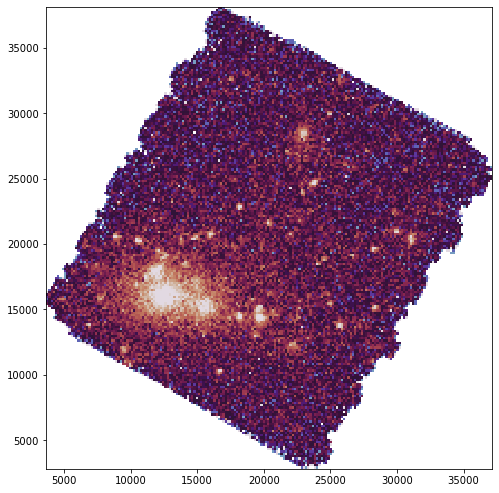

In [16]:
#This is just a plot of where the compact sources are. Used for debugging and can be ignored. 
import matplotlib.colors as colors
from matplotlib import cm
fig, ax = plt.subplots(1, 1, figsize=(8, 8.5))
ax.hist2d(table['xcentroid'],table['ycentroid'], bins=200, cmap='twilight', norm=colors.LogNorm(vmin=1, vmax=50))#, vmin=30, vmax=200.5)